# Learing the Stein discrepancy directly

In [3]:
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models

from jax.experimental import optimizers

key = random.PRNGKey(0)

In [4]:
@partial(jit, static_argnums=1)
def get_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

### Parameters

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, **kwargs)


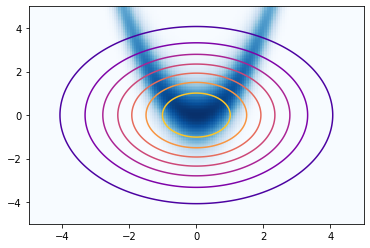

In [5]:
setup = distributions.banana_proposal
target, proposal = setup.get()
sizes = [32, 32, 2]
sample_every=True

setup.plot()

In [6]:
def get_ksds(proposal, kernel):
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(400)
        ksds.append(compute_ksd(samples))
    return ksds

# Train

In [11]:
learning_rate = 1e-2
learner = models.SDLearner(target=target,
                           key=key,
                            sizes=sizes,
                            learning_rate=learning_rate,
                            lambda_reg=1/2)

batch_size=400

In [12]:
if sample_every:
    learner.train_sampling_every_time(proposal, n_steps=1000, batch_size=1000)
else:
    samples = proposal.sample(batch_size)
    validation_samples = proposal.sample(batch_size)
    learner.train(samples=samples, validation_samples=validation_samples, n_steps=10**3)

100%|██████████| 1000/1000 [00:24<00:00, 41.42it/s]


In [13]:
# compute optimal KSD
div = 2*learner.lambda_reg
def kl_gradient(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div
sds = []
for _ in range(100):
    samples = proposal.sample(400)
    sds.append(get_sd(samples, kl_gradient))

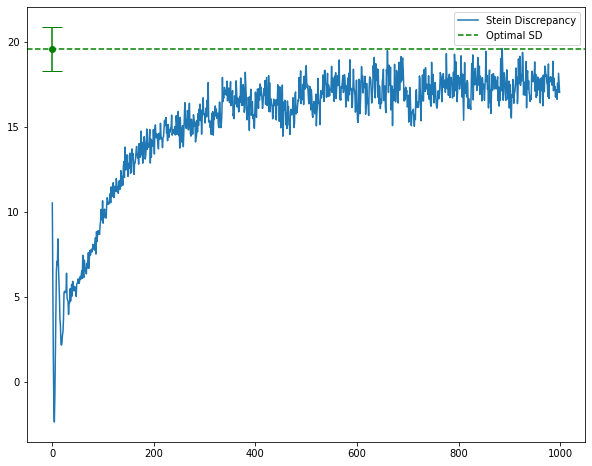

In [15]:
fig, axs = plt.subplots(figsize=[10, 8])
plt.plot(learner.rundata["training_sd"], label="Stein Discrepancy")
plt.errorbar(x=0, y=onp.mean(sds), yerr=onp.std(sds), fmt="o", capsize=10, color="green")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal SD", color="green")
plt.legend()
# plt.ylim((0, 11))

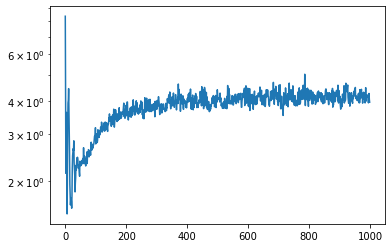

In [16]:
plt.plot(learner.rundata["l2_norm"])
plt.yscale("log")

## Plot the KL gradient and the learned approximation

In [20]:
learned_stein_gradient = jit(utils.negative(learner.get_field()))
rbf_stein_gradient = jit(stein.get_phistar(kernels.get_rbf_kernel(.1), target.logpdf, samples))

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, **kwargs)


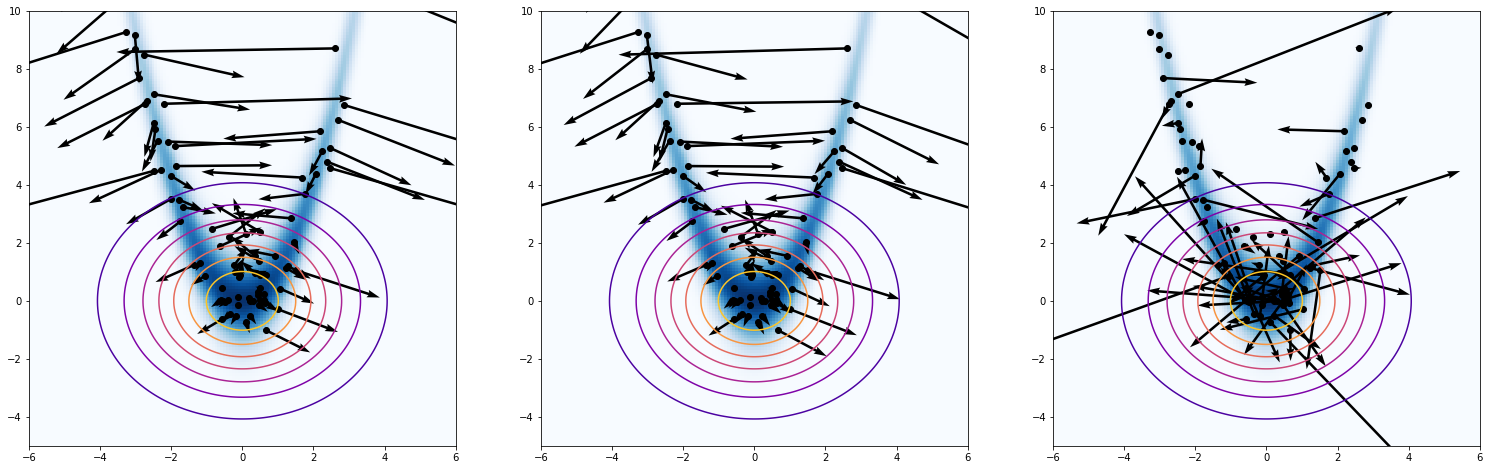

In [21]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
axs = axs.flatten()
def log_diff(x):
    return (target.logpdf(x) - proposal.logpdf(x)) / div

samples = None
samples = proposal.sample(100)
xlims = [-6, 6]
ylims = [-5, 10]
fields = (kl_gradient, learned_stein_gradient, rbf_stein_gradient)
scales = (20, 20, 0.2)
for ax, vector_field, scale in zip(axs, fields, scales):
#     ax.pcolormesh(xx, yy, zz, vmin=-50, vmax=1, cmap="Blues")
    setup.plot(ax=ax, xlims=xlims, ylims=ylims)
    plot.quiverplot(vector_field, samples=samples, num_gridpoints=10, scale=scale, xlims=xlims, ylims=ylims, ax=ax)
    ax.set_ylim(ylims)

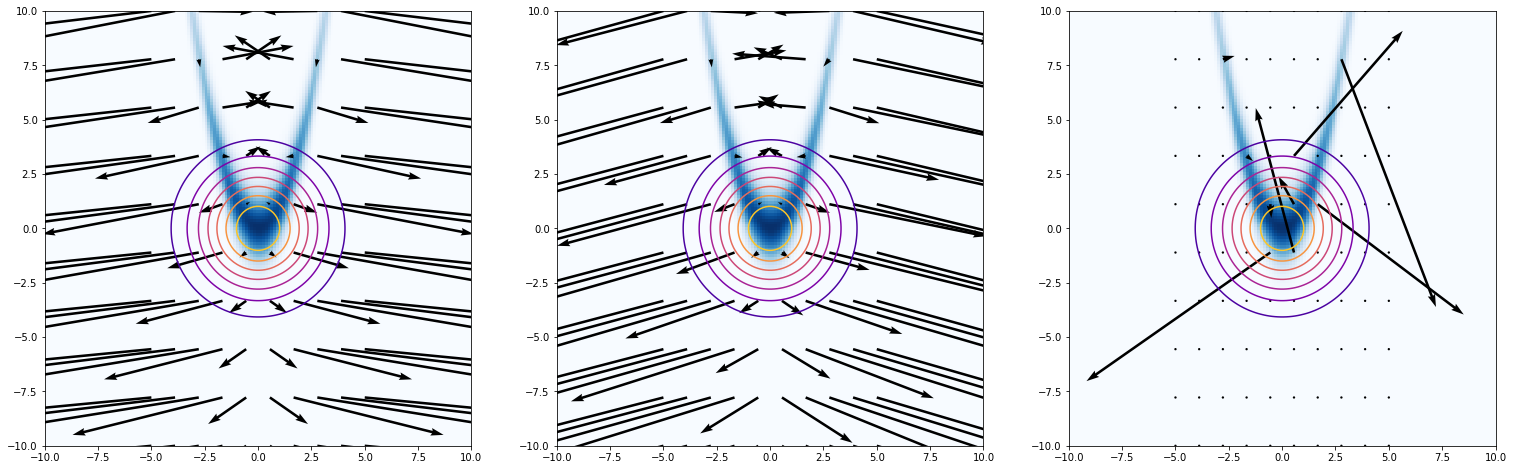

In [22]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
axs = axs.flatten()
def log_diff(x):
    return (target.logpdf(x) - proposal.logpdf(x)) / div

xx, yy, zz = plot.make_meshgrid(log_diff, (-15, 15))
xlims = [-5, 5]
ylims = [-10, 10]

fields = (kl_gradient, learned_stein_gradient, rbf_stein_gradient)
scales = (100, 100, .1)
for ax, vector_field, scale in zip(axs, fields, scales):
#     ax.pcolormesh(xx, yy, zz, vmin=-50, vmax=1, cmap="Blues")
    setup.plot(ax=ax, lims=(-10, 10))
    plot.quiverplot(vector_field, num_gridpoints=10, scale=scale, xlims=xlims, ylims=ylims, ax=ax)

In [23]:
stein_gradient = learned_stein_gradient
def phi_norm(x): return np.linalg.norm(stein_gradient(x))**2
np.mean(vmap(phi_norm)(samples))

DeviceArray(20.186989, dtype=float32)

In [24]:
kl_gradient
def dkl_norm(x): return np.linalg.norm(kl_gradient(x))**2
np.mean(vmap(dkl_norm)(samples))

DeviceArray(22.842644, dtype=float32)